# Imports and Data Loading

In [1]:
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker

import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

In [2]:
# create engine and connect to the db
engine = create_engine('sqlite:///hawaii.sqlite')
Session = sessionmaker(bind=engine)
session = Session()

In [3]:
# Look at the tables
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(f'Table Names: {table_names}')
for table in table_names:
    print(table)
    for col in inspector.get_columns(table):
        print(f"name: {col['name']}, type: {col['type']}")
    print()

Table Names: ['measurement', 'station']
measurement
name: id, type: INTEGER
name: station, type: TEXT
name: date, type: TEXT
name: prcp, type: FLOAT
name: tobs, type: FLOAT

station
name: id, type: INTEGER
name: station, type: TEXT
name: name, type: TEXT
name: latitude, type: FLOAT
name: longitude, type: FLOAT
name: elevation, type: FLOAT



In [4]:
# Create the Base and models
Base = automap_base()
Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

# Precipitation Analysis

In [5]:
# Get the most recent date
most_recent_date, =  session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

# Get the date one year prior to the most_recent date and convert it to the same format
start_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(weeks=52)
start_date = start_date.strftime('%Y-%m-%d')
start_date


2017-08-23


'2016-08-24'

In [6]:
# Get the precipitation data
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= start_date)\
    .order_by(Measurement.date).all()

In [7]:
# Load into a dataframe
cols = ['Date', 'prcp']
precipitation_df = pd.DataFrame(data=precipitation_data, columns=cols)
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.index

DatetimeIndex(['2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
               '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-25',
               '2016-08-25', '2016-08-25',
               ...
               '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22',
               '2017-08-22', '2017-08-22', '2017-08-23', '2017-08-23',
               '2017-08-23', '2017-08-23'],
              dtype='datetime64[ns]', name='Date', length=2223, freq=None)

/Users/TheDoctor/.virtualenvs/10-Advanced-Data-Storage-and-Retrieval/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/TheDoctor/.virtualenvs/10-Advanced-Data-Storage-and-Retrieval/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


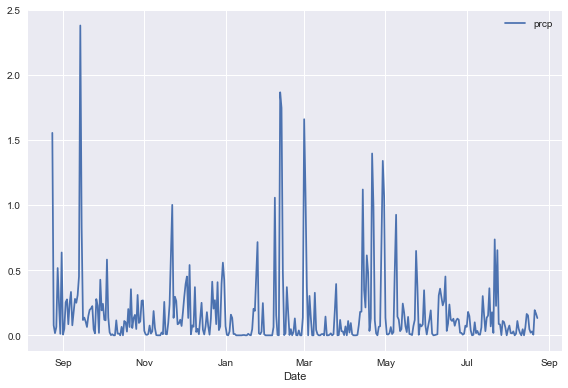

In [8]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
sns.lineplot(data=precipitation_df, ci=None, ax=ax)
# ax.set_xticklabels(size=8, rotation=30, labels=precipitation_df.index.strftime)

my_format = DateFormatter('%b')
ax.xaxis.set_major_formatter(my_format)

fig.tight_layout()
fig.show()

In [9]:
# Summary Data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [10]:
# Total number of stations
num_stations = session.query(func.count(Station.id)).first()
print(f'There are {num_stations[0]} weather measurement stations.')

There are 9 weather measurement stations.


In [11]:
# Total number of observations per station
measurement_counts_query = session.query(Station.station, func.count(Measurement.id))\
    .filter(Station.station == Measurement.station)\
    .group_by(Station.id).order_by(func.count(Measurement.id).desc())

for station in measurement_counts_query.all():
    print('Station {} has {} observations'.format(*station))

print('\nStation {} has the most observations ({})'.format(*measurement_counts_query.first()))

Station USC00519281 has 2772 observations
Station USC00519397 has 2724 observations
Station USC00513117 has 2709 observations
Station USC00519523 has 2669 observations
Station USC00516128 has 2612 observations
Station USC00514830 has 2202 observations
Station USC00511918 has 1979 observations
Station USC00517948 has 1372 observations
Station USC00518838 has 511 observations

Station USC00519281 has the most observations (2772)


In [12]:
# Find the station with the most observations over the last 12 months
station, = session.query(Measurement.station)\
    .filter(Measurement.date >= start_date)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc()).first()

In [13]:
# Get the temp data
temp_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == station).all()

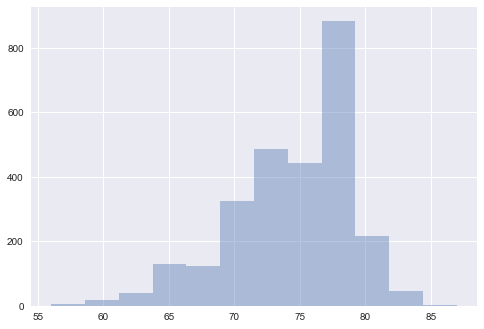

In [14]:
# plot it
sns.distplot(pd.DataFrame(data=temp_data), kde=False, bins=12)
